In [60]:
import numpy as np
import pandas as pd
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

#Climate path
# base_path = "gs://agriculture-sara/Data sets/Clusters/Modeling/Climate/"
#Clustering other path
base_path = "gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/"

# Specify the input path of the data set
# input_path =  "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
input_path =  "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Library_Daily_Albedo_NDVI_LST_Cleaned.csv"

df = pd.read_csv(input_path, delimiter=',')

#Only ameriflux for climate
#TODO: uncomment out only when clustering for climate
# df = df[df["Site Id"].str.startswith('US-')]
df.head()

#Drop columns

dates = df['Date']
#Manual
# columnsToDrop = ['Date','Year','Month','Day',
#                  'Vegetation', 'Latitude', 'Longitude', 
#                  'G','G-1','G-2','G-3','G-4','G-5',
#                  'Climate_1', 'Climate_2', 'Climate_3',
#                  'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
#                  'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
#                  'Longitude_5', 'Longitude_6',
#                  'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
#                  'H_bowen_corr-5', 'C_BOWENS',
#                  'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
#                  'LE', 'LE_bowen_corr',
#                  'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
#                  'Elevation(m)_5', 'Elevation(m)_6',
#                  'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4',
#        'Site Id_5', 'Site Id_6']

#Library
columnsToDrop = ['Date', 'Year','Month','Day', 'Latitude','Longitude',
                 'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                 'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                 'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                 'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr','LE_ebr_corr(mm)',
                 'ET_bowen','ET_bowen_corr','ET_bowen_corr(mm)','ET_ebr','ET_ebr_corr',
                  'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                 'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                 'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1', 'ETo',
                 'Climate_2','Climate_3', 'Latitude_1',
                 'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                 'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                 'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                 'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'SW_IN', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4',
       'Site Id_5', 'Site Id_6']


df = df.drop(columnsToDrop, axis = 1)

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df

#Encode climate only for when clustering on climate
df = binary_encode_column(df, "Climate")
df = binary_encode_column(df, "Site Id")
# df.drop(columns=['Site Id_0'], inplace=True)
#Uncomment below when clustering on climate
df.drop(columns=['Climate', 'Site Id_0', 'Climate_0'], inplace=True)

#Drop NaN values
df.dropna(inplace=True)
df_original = df

print("columns:", df.columns)

#Specify the output column
output_column = "LE_bowen_corr(mm)"

#Split data
X = df.drop([output_column, 'Site Id'], axis = 1)
Y = df[output_column]
print(X.shape, Y.shape)


# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X, norm="l2") 

# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(X_normalized)
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_scaled, columns=X.columns) 

columns: Index(['Site Id', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr(mm)', 'ET_ebr_corr(mm)',
       'EEflux LST', 'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3',
       'EEflux LST-4', 'EEflux LST-5', 'EEflux NDVI', 'EEflux NDVI-1',
       'EEflux NDVI-2', 'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5',
       'EEflux Albedo', 'EEflux Albedo-1', 'EEflux Albedo-2',
       'EEflux Albedo-3', 'EEflux Albedo-4', 'EEflux Albedo-5', 'Climate_1',
       'Climate_2', 'Climate_3', 'Site Id_1', 'Site Id_2', 'Site Id_3',
       'Site Id_4', 'Site Id_5'],
      dtype='object')
(6600, 52) (6600,)


## Kmeans

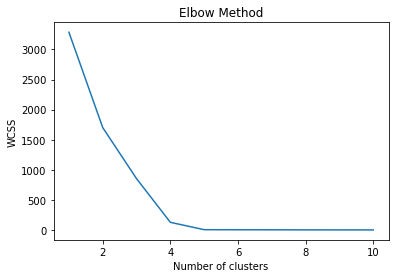

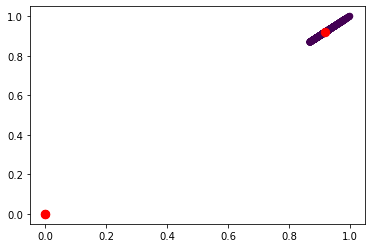

[2 2 2 ... 2 2 2]
Counter({2: 3509, 1: 2159, 0: 932})


In [61]:
#Set clustering parameter
k = 3
parameter_name = "Climate_Cluster_"
cluster_columns = ['Climate_1', 'Climate_2', 'Climate_3']

# parameter_name = "WS_RH_Cluster_"
# cluster_columns = ['WS', 'RH']

# parameter_name = "RH_Cluster_"
# cluster_columns = ['RH']

# parameter_name = "WS_Cluster_"
# cluster_columns = ['WS']

#Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_normalized[cluster_columns])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


#Clustering kmeans
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_normalized[cluster_columns])
plt.scatter(X_normalized[cluster_columns[0]], X_normalized[cluster_columns[0]], c=pred_y, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 0], s=70, c='red')
plt.show()

#Get count of records per cluster
print(kmeans.labels_)
print(Counter(kmeans.labels_))

df_original["Cluster"] = kmeans.labels_

## Dendograms

[0 1 1 ... 1 1 0]
Counter({1: 3652, 0: 2948})


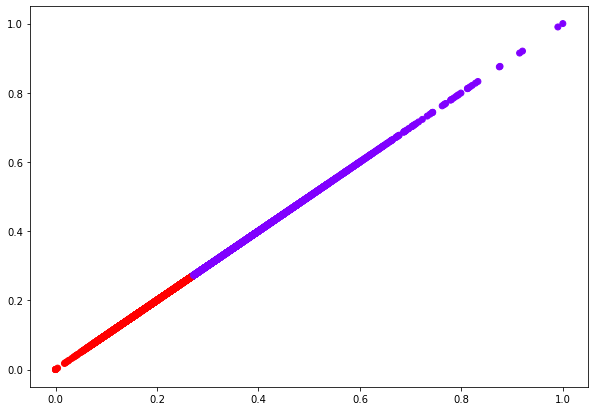

In [56]:
# #Set clustering parameter
k = 2
cluster_columns = ['WS']
parameter_name = "WS_Cluster_"
# cluster_columns = ['WS', 'RH']
# cluster_columns = ['TA', 'WS', 'RH']

# parameter_name = "Climate_Cluster_"
# cluster_columns = ['Climate_1', 'Climate_2', 'Climate_3']

ahc_model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
ahc_model.fit_predict(X_normalized[cluster_columns])

plt.figure(figsize=(10, 7))  
plt.scatter(X_normalized[cluster_columns[0]], X_normalized[cluster_columns[0]], c=ahc_model.labels_, cmap='rainbow') 

#Get count of records per cluster
print(ahc_model.labels_)
print(Counter(ahc_model.labels_))

df_original["Cluster"] = ahc_model.labels_

In [62]:
unique_clusters = df_original["Cluster"].unique()
print(unique_clusters)


def generate_lags(df, column, lags_count): 
    for i in range(lags_count):
        lag_name = column + "-" + str(i + 1)
        df[lag_name] = df[column].shift(i + 1)
    return df

def get_all_matching_columns(df, keyword):
    return df.filter(like=keyword).columns

def drop_invalid_lags(df):
    '''This function will drop all the lags'''
    ws_list = list(get_all_matching_columns(df, "WS-"))
    rh_list = list(get_all_matching_columns(df, "RH-"))
    ta_list = list(get_all_matching_columns(df, "TA-"))
    g_list = list(get_all_matching_columns(df, "G-"))
    h_list = list(get_all_matching_columns(df, "H-"))
    h_corr_list = list(get_all_matching_columns(df, "H_bowen_corr-"))
    netrad_list = list(get_all_matching_columns(df, "NETRAD-"))
    columns_to_drop = []
    columns_to_drop.extend(ws_list)
    columns_to_drop.extend(rh_list)
    columns_to_drop.extend(ta_list)
    columns_to_drop.extend(g_list)
    columns_to_drop.extend(h_list)
    columns_to_drop.extend(h_corr_list)
    columns_to_drop.extend(netrad_list)
    df = df.drop(columns_to_drop, axis=1) 
    return df

def generate_input_lags(df):
    '''This function generates the lags for the list of input columns'''
    input_columns = []
    if "RH" in df.columns:
        input_columns.append("RH")
    if "TA" in df.columns:
        input_columns.append("TA")
    if "WS" in df.columns:
        input_columns.append("WS") 
    input_columns.extend(["G", "NETRAD"])
    h_corr_name = "H_bowen_corr"
    if (h_corr_name in df.columns):
        input_columns.append(h_corr_name)
    elif "H" in df.columns:
        input_columns.append("H")
        
    for k in range(len(input_columns)):
        col = input_columns[k]
        if col in df.columns:
            df = generate_lags(df, col, 5)
    return df


df_original = drop_invalid_lags(df_original)
cluster_num = k

algorithm_name = "Kmeans"
# algorithm_name = "Dendograms"

for i in range(len(unique_clusters)):
    cluster = unique_clusters[i]
    df_sub = df_original[df_original["Cluster"] == cluster]
    df_sub = generate_input_lags(df_sub)
    file_path = os.path.join(base_path, algorithm_name + "/" + str(cluster_num))
    print(file_path)
    file_name = algorithm_name + "_" + parameter_name + str(cluster)
    export_path = os.path.join(file_path, file_name + ".csv")
    print("export path " + export_path)
    
    df_sub["Date"] = dates
    export_csv = df_sub.to_csv(export_path, index=None, header=True)  
    
    
for col in cluster_columns: 
    print("k = " + str(cluster_num) + "\n " + col + ":")
    for cluster in unique_clusters:
        min_cl = df_original[df_original["Cluster"] == cluster][col].min()
        max_cl = df_original[df_original["Cluster"] == cluster][col].max()
        print("C" + str(cluster) + " " + str(min_cl) + " - " + str(max_cl))

[2 1 0]
gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/Kmeans/3
export path gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/Kmeans/3/Kmeans_Climate_Cluster_2.csv
gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/Kmeans/3
export path gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/Kmeans/3/Kmeans_Climate_Cluster_1.csv
gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/Kmeans/3
export path gs://agriculture-sara/Data sets/Clusters/Modeling/Library/Climate/Kmeans/3/Kmeans_Climate_Cluster_0.csv
k = 3
 Climate_1:
C2 0 - 0
C1 0 - 0
C0 1 - 1
k = 3
 Climate_2:
C2 0 - 1
C1 1 - 1
C0 0 - 0
k = 3
 Climate_3:
C2 1 - 1
C1 0 - 0
C0 0 - 1
